<a href="https://colab.research.google.com/github/frank-morales2020/MLxDL/blob/main/MSFT_CREWAI_MAGISTRAL_FINANCE_STOCK2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://console.mistral.ai/usage

In [ ]:
from IPython import get_ipython
from IPython.display import display


!pip install openai yfinance colab-env -q
!pip install openai-agents -q

# crewai with Mistral

# Install crewai and langchain-openai (langchain-openai is often used with CrewAI for tool compatibility, even with LiteLLM)
!pip install crewai langchain-openai -q
!pip install pydantic  -q # Ensure pydantic is installed
!pip install 'crewai[tools]' -q
!pip install litellm -q # Ensure litellm is installed

!pip install colab-env --quiet
!pip install mistralai --quiet

# Install Hugging Face libraries
!pip install  --upgrade transformers datasets accelerate evaluate bitsandbytes --quiet

In [ ]:
from google.colab import userdata
from litellm import completion
import os
import openai
import colab_env

from mistralai import Mistral
api_key = os.environ["MISTRAL_API_KEY"]
client = Mistral(api_key=api_key)

client = Mistral(api_key=api_key)  # Use MistralClient instead of Mistral
model_list = client.models.list()

#for model in model_list.data:
    #print(model.id)
    #print(model.created)
    #print(model.owned_by)

model=model_list.data[45].id

print(f"Model name: {model}")

messages = [{"role": "user", "content": "What is the best Cuban poet?"}]

chat_response = client.chat.complete(  # Use client.chat.complete
    model=model,
    messages=messages,
)
print(chat_response.choices[0].message.content)

Mounted at /content/gdrive
Model name: magistral-medium-latest
<think>
Okay, the user asked for the best Cuban poet. Let me think about this. First, I need to consider what makes a poet "the best." Is it based on popularity, critical acclaim, influence, or personal preference? Since the user didn't specify, I'll assume they're asking for a poet who is widely recognized and celebrated for their work, both in Cuba and internationally.

Cuba has a rich literary tradition, and several poets have gained significant recognition. Some names that come to mind are Nicolás Guillén, José Martí, and Dulce María Loynaz.

Let me think about each of these poets:

1. **José Martí**: He is often considered the national hero of Cuba, known not only for his poetry but also for his role in the Cuban independence movement. His works, such as "Versos sencillos" (Simple Verses), are widely celebrated.

2. **Nicolás Guillén**: He is another prominent figure in Cuban literature. Known for his work that often a

LiteLLM Test call successful with Mistral!
Hello! How can I assist you today? If you're up for it, I'd be happy to share an interesting fact or a light joke to start our conversation. What do you say?
Database initialized.


ERROR:yfinance:HTTP Error 401: 


Successfully stored MSFT's data for the last 25 years.
Basic Financial Metrics for MSFT (Data Year: 2025):
 Recent Closing Price: $478.04 (on 2025-06-17)
 Average Closing Price (Last 30 Days): $465.04
 Price Change Percentage (Last 30 Days): 2.79%


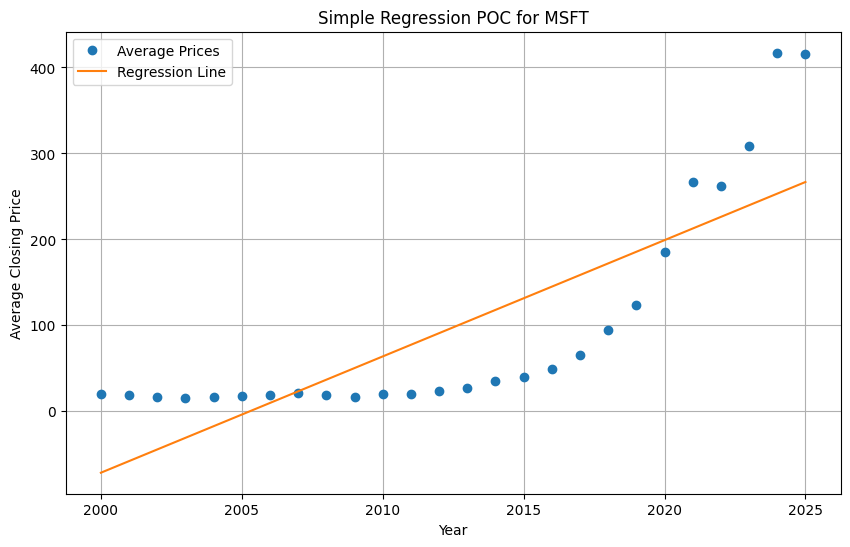

ERROR:yfinance:HTTP Error 401: 


+--------+-------------------------+
|   Year |   Average Closing Price |
+========+=========================+
|   2000 |                 20.2406 |
+--------+-------------------------+
|   2001 |                 19.1693 |
+--------+-------------------------+
|   2002 |                 16.7194 |
+--------+-------------------------+
|   2003 |                 16.0651 |
+--------+-------------------------+
|   2004 |                 17.0443 |
+--------+-------------------------+
|   2005 |                 17.9978 |
+--------+-------------------------+
|   2006 |                 18.5334 |
+--------+-------------------------+
|   2007 |                 21.767  |
+--------+-------------------------+
|   2008 |                 19.3144 |
+--------+-------------------------+
|   2009 |                 17.0717 |
+--------+-------------------------+
|   2010 |                 20.4864 |
+--------+-------------------------+
|   2011 |                 20.1975 |
+--------+-------------------------+
|

In [ ]:
from mistralai import Mistral
api_key = os.environ["MISTRAL_API_KEY"]
client = Mistral(api_key=api_key)

try:
    # Use the Mistral model identifier recognized by LiteLLM
    response = completion(
        model="mistral/mistral-large-latest", # Use the Magistral model
        messages=[{"role": "user", "content": "hello"}],
        # LiteLLM should pick up MISTRAL_API_KEY from environment variables
        # api_key=mistral_api_key_test # You can explicitly pass it, but env var is common
    )
    print("LiteLLM Test call successful with Mistral!")
    print(response.choices[0].message.content)
except Exception as e:
    print(f"LiteLLM Test call failed with Mistral: {e}")
finally:
    # Optionally unset the env var after the test if needed, though usually left for crewai
    # Re-setting it later for the main crew execution
    if 'MISTRAL_API_KEY' in os.environ:
         # Keep it set for the main crew execution
         pass
        # del os.environ['MISTRAL_API_KEY'] # Clean up environment variable after test if desired


import os
#import colab_env # Commented out as it was in the original code
import sqlite3
from google.colab import userdata
import yfinance as yf
import asyncio
import nest_asyncio
import random # Imported but not used
import re # Imported but not used
import logging
import typing
import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate
from datetime import date
from dateutil.relativedelta import relativedelta
import json

# Import litellm
from litellm import litellm

# crewai imports
from crewai import Agent, Task, Crew, Process
from pydantic import BaseModel, Field
from crewai.tools import BaseTool

# Set up logging
logging.basicConfig(level=logging.INFO, filename="financial_analysis.log")
logger = logging.getLogger(__name__)

# Configuration
DB_NAME = "financial_data.db"

# Get the Mistral API key from Colab userdata
# Ensure MISTRAL_API_KEY is set in Colab userdata
mistral_api_key = userdata.get('MISTRAL_API_KEY')

# Set the MISTRAL_API_KEY environment variable for LiteLLM
# LiteLLM uses this env var to authenticate with Mistral API
# This is set here again to ensure it's available for the crew run if it was unset after the test
os.environ['MISTRAL_API_KEY'] = mistral_api_key


# Specify the Mistral model identifier used by LiteLLM for Magistral
mistral_llm = "mistral/mistral-large-latest"


nest_asyncio.apply() # Apply nest_asyncio for async operations in notebook

# 1. Initialize the SQLite Database
def initialize_database(db_name=DB_NAME):
    """Initializes the SQLite database."""
    try:
        with sqlite3.connect(db_name) as conn:
            cursor = conn.cursor()
            cursor.execute(
                """
                CREATE TABLE IF NOT EXISTS stocks (
                    ticker TEXT PRIMARY KEY,
                    company_name TEXT,
                    sector TEXT
                )
                """
            )
            cursor.execute(
                """
                CREATE TABLE IF NOT EXISTS historical_prices (
                    ticker TEXT,
                    date TEXT,
                    close REAL,
                    volume INTEGER,
                    PRIMARY KEY (ticker, date),
                    FOREIGN KEY (ticker) REFERENCES stocks (ticker)
                )
                """
            )
            logger.info("Database initialized.")
            print("Database initialized.")
    except sqlite3.Error as e:
        logger.error(f"SQLite Error: {e}", exc_info=True)
        print(f"SQLite Error: {e}")

# 2. Populate the Database
# Changed default ticker back to MSFT as per your original code context
def populate_stock_data(db_name=DB_NAME, ticker="MSFT", years=25):
    """Populates the database with stock data for a given ticker."""
    try:
        with sqlite3.connect(db_name) as conn:
            cursor = conn.cursor()
            stock = yf.Ticker(ticker)
            # Use start and end dates for clarity, calculated from 25 years ago
            end_date = date.today()
            start_date = end_date - relativedelta(years=years)
            history = stock.history(start=start_date.strftime('%Y-%m-%d'), end=end_date.strftime('%Y-%m-%d'))

            if history.empty:
                logger.warning(f"No data found for ticker {ticker} for the last {years} years.")
                print(f"No data found for ticker {ticker} for the last {years} years.")
                return

            # Check if stock info is available before inserting company details
            company_name = stock.info.get("longName", ticker) # Use ticker as fallback
            sector = stock.info.get("sector", "Unknown") # Use Unknown as fallback

            cursor.execute(
                "INSERT OR IGNORE INTO stocks VALUES (?, ?, ?)",
                (ticker, company_name, sector),
            )

            # Prepare data for bulk insertion - much more efficient
            data_to_insert = []
            for date_idx, row in history.iterrows():
                date_str = date_idx.strftime("%Y-%m-%d")
                data_to_insert.append((ticker, date_str, row["Close"], int(row["Volume"])))

            # Insert data, ignoring duplicates based on PRIMARY KEY (ticker, date)
            cursor.executemany(
                "INSERT OR IGNORE INTO historical_prices VALUES (?, ?, ?, ?)",
                data_to_insert
            )
            conn.commit() # Commit after executemany

            logger.info(f"Successfully stored {ticker}'s data for the last {years} years.")
            print(f"Successfully stored {ticker}'s data for the last {years} years.")
    except Exception as e:
        logger.error(f"Error populating database with {ticker} data: {e}", exc_info=True)
        print(f"Error populating database with {ticker} data: {e}")


# 3. Define a Function Tool to Use SQLite (analyze_stock_data_from_db)
# This function is not used by the crewai agents directly in this setup,
# but is kept from your original code if you need it elsewhere.
def analyze_stock_data_from_db(ticker, db_name=DB_NAME):
    """Analyzes historical stock data."""
    try:
        with sqlite3.connect(db_name) as conn:
            cursor = conn.cursor()
            # Combine queries for efficiency
            cursor.execute(
                """
                SELECT close, AVG(volume)
                FROM historical_prices
                WHERE ticker = ?
                ORDER BY date DESC
                LIMIT 1
                """,
                (ticker,),
            )
            result = cursor.fetchone()

            if result:
                recent_price, average_volume = result
                analysis = f"Stock analysis for {ticker} (from SQLite DB):\n"
                analysis += f" Recent closing price: ${recent_price:.2f}\n"
                analysis += f" Average trading volume: {average_volume:.0f}\n"
                return analysis
            return f"No recent price data found for ticker {ticker}."
    except Exception as e:
        logger.error(f"Error analyzing stock data for {ticker}: {e}", exc_info=True)
        return f"Error analyzing stock data for {ticker}: {e}"

# Initialize and populate the database
initialize_database()
# Call populate_stock_data with the desired ticker, e.g., "MSFT"
populate_stock_data(ticker="MSFT")

# Functions for Basic Metrics and Regression POC (Keeping these for standalone use if needed)
def calculate_basic_metrics_with_year(ticker="MSFT", db_name=DB_NAME):
    """Calculates basic financial metrics and includes the year."""
    try:
        with sqlite3.connect(db_name) as conn:
            cursor = conn.cursor()

            # 1. Get the most recent closing price, date, and year
            cursor.execute(
                """
                SELECT Close, Date, strftime('%Y', Date) AS Year
                FROM historical_prices
                WHERE ticker = ?
                ORDER BY date DESC
                LIMIT 1
                """,
                (ticker,),
            )
            result = cursor.fetchone()
            if result:
                recent_price, recent_date, recent_year = result

                # 2. Calculate the average closing price over the last 30 days
                cursor.execute(
                    """
                    SELECT AVG(Close)
                    FROM historical_prices
                    WHERE ticker = ?
                    AND date >= date('now', '-30 days')
                    """,
                    (ticker,),
                )
                avg_price_30_days_result = cursor.fetchone()
                avg_price_30_days = avg_price_30_days_result[0] if avg_price_30_days_result else None

                # Display the results including the year
                print(f"Basic Financial Metrics for {ticker} (Data Year: {recent_year}):")
                print(f" Recent Closing Price: ${recent_price:.2f} (on {recent_date})")
                if avg_price_30_days is not None:
                    print(f" Average Closing Price (Last 30 Days): ${avg_price_30_days:.2f}")
                     # 3. Calculate the price change percentage over the last 30 days
                    price_change_percentage = (
                        (recent_price - avg_price_30_days) / avg_price_30_days
                    ) * 100
                    print(
                        f" Price Change Percentage (Last 30 Days): {price_change_percentage:.2f}%"
                    )
                else:
                     print(" Not enough data for 30-day average.")
            else:
                print(f"No data found for ticker {ticker} to calculate basic metrics.")

    except Exception as e:
        print(f"Error calculating basic metrics: {e}")

# Run the analysis for basic metrics (standalone example)
calculate_basic_metrics_with_year(ticker="MSFT") # Specify ticker for clarity

def simple_regression_poc(ticker="MSFT", db_name=DB_NAME):
    """Performs a simple linear regression and plots the results."""
    try:
        with sqlite3.connect(db_name) as conn:
            cursor = conn.cursor()
            # Fetch yearly average closing prices (simplified query)
            cursor.execute(
                """
                SELECT strftime('%Y', Date), AVG(Close)
                FROM historical_prices
                WHERE ticker = ?
                GROUP BY 1
                ORDER BY 1
                """,
                (ticker,),
            )
            data = cursor.fetchall()

            if not data:
                print(f"No data available for regression for ticker {ticker}.")
                return

            # Extract years and average prices
            years, avg_prices = zip(*data) # Using zip for direct unpacking
            years = np.array([int(year) for year in years]) # Convert to numerical
            avg_prices = np.array(avg_prices)

            # Perform linear regression
            slope, intercept = np.polyfit(years, avg_prices, 1)
            regression_line = slope * years + intercept

            # Plot the results (simplified plotting)
            plt.figure(figsize=(10, 6)) # Optional: make plot bigger
            plt.plot(years, avg_prices, 'o', label="Average Prices")
            plt.plot(years, regression_line, label="Regression Line")
            plt.xlabel("Year")
            plt.ylabel("Average Closing Price")
            plt.title(f"Simple Regression POC for {ticker}")
            plt.legend()
            plt.grid(True) # Optional: add grid
            plt.show()

    except Exception as e:
        print(f"Error in simple_regression_poc: {e}")

# Run the POC (standalone example)
simple_regression_poc(ticker="MSFT") # Specify ticker for clarity

def simple_regression_poc_with_printed_table(ticker="MSFT", db_name=DB_NAME):
    """Performs a simple linear regression, plots the results, and prints a table."""
    try:
        with sqlite3.connect(db_name) as conn:
            cursor = conn.cursor()
            # Fetch yearly average closing prices
            cursor.execute(
                """
                SELECT strftime('%Y', Date), AVG(Close)
                FROM historical_prices
                WHERE ticker = ?
                GROUP BY 1
                ORDER BY 1
                """,
                (ticker,),
            )
            data = cursor.fetchall()

            if not data:
                print(f"No data available for regression for ticker {ticker}.")
                return

            # Table Printing
            headers = ["Year", "Average Closing Price"]
            print(tabulate(data, headers=headers, tablefmt="grid"))
            # End Table Printing

            # Extract years and average prices for regression and plotting
            years, avg_prices = zip(*data)
            years = np.array([int(year) for year in years])
            avg_prices = np.array(avg_prices)

            # Perform linear regression
            slope, intercept = np.polyfit(years, avg_prices, 1)
            regression_line = slope * years + intercept

            # Plot the results (commented out as in original)
            #plt.figure(figsize=(10, 6)) # Optional: make plot bigger
            #plt.plot(years, avg_prices, 'o', label="Average Prices")
            #plt.plot(years, regression_line, label="Regression Line")
            #plt.xlabel("Year")
            #plt.ylabel("Average Closing Price")
            #plt.title(f"Simple Regression POC for {ticker}")
            #plt.legend()
            #plt.grid(True) # Optional: add grid
            #plt.show()

    except Exception as e:
        print(f"Error in simple_regression_poc_with_printed_table: {e}")

# Run the POC with table printing (standalone example)
simple_regression_poc_with_printed_table(ticker="MSFT") # Specify ticker for clarity


def get_market_cap(ticker="MSFT"):
    """Retrieves and formats the market capitalization of a stock."""
    try:
        stock = yf.Ticker(ticker)
        market_cap = stock.info.get("marketCap")
        if market_cap is not None:
            # Corrected formatting logic: handle units without appending "Trillion" directly
            if market_cap >= 1e12: # Trillion
                return f"The market capitalization of {ticker} is ${market_cap/1e12:,.2f} Trillion"
            elif market_cap >= 1e9: # Billion
                return f"The market capitalization of {ticker} is ${market_cap/1e9:,.2f} Billion"
            elif market_cap >= 1e6: # Million
                return f"The market capitalization of {ticker} is ${market_cap/1e6:,.2f} Million"
            else:
                return f"The market capitalization of {ticker} is ${market_cap:,.0f}"
        else:
            return f"Market capitalization not found for {ticker}"
    except Exception as e:
        return f"Error retrieving market capitalization: {e}"

# Get and print the formatted market capitalization (standalone example for MSFT)
market_cap_info = get_market_cap(ticker="MSFT") # Specify ticker for clarity
print(market_cap_info)


# --- Define Pydantic Models for Tool Arguments ---
# These models define the expected input schema for the tools.

class RegressionToolInput(BaseModel):
    """Input schema for the regression_tool."""
    years: typing.List[int] = Field(description="A list of historical years (integers).")
    avg_prices: typing.List[float] = Field(description="A list of average closing prices corresponding to the years (floats).")

class DataRetrievalToolInput(BaseModel):
    """Input schema for the data_retrieval_tool."""
    ticker: str = Field(description="The stock ticker symbol (e.g., 'MSFT').")

# The time_calculation_tool has no arguments, so it doesn't need a BaseModel.


# --- Define Tools using CrewAI's BaseTool ---

class RegressionTool(BaseTool):
    name: str = "regression_tool"
    description: str = "Performs linear regression on historical data (years, average prices) to predict future stock price 6 months out. Input: two lists (years and average prices). Returns predicted price (float) or error message (str)."
    args_schema: typing.Type[BaseModel] = RegressionToolInput # Link to the input schema

    def _run(self, years: typing.List[int], avg_prices: typing.List[float]) -> float | str:
        """Performs linear regression and predicts the price in 6 months based on provided historical yearly data."""
        try:
            x = np.array(years)
            y = np.array(avg_prices)

            if len(x) < 2:
                return "Error: Need at least 2 data points for linear regression."

            slope, intercept = np.polyfit(x, y, 1)
            # Predict price 6 months from the last data point's year
            # Representing 6 months as 0.5 years added to the last year
            future_year = years[-1] + 0.5
            predicted_price = slope * future_year + intercept
            # Ensure predicted price is not negative
            predicted_price = max(0, predicted_price)
            return float(predicted_price)
        except Exception as e:
            logger.error(f"Error in RegressionTool._run: {e}", exc_info=True)
            return f"Error performing regression: {e}"

class DataRetrievalTool(BaseTool):
    name: str = "data_retrieval_tool"
    description: str = "Retrieves historical stock data (years and average closing prices) from the database for a given ticker. Input: stock ticker symbol (string). Returns data as a JSON string or error details."
    args_schema: typing.Type[BaseModel] = DataRetrievalToolInput # Link to the input schema

    def _run(self, ticker: str) -> str:
        """Retrieves historical stock data (years and average closing prices) from the database for a given ticker."""
        try:
            with sqlite3.connect(DB_NAME) as conn:
                cursor = conn.cursor()
                cursor.execute(
                    """
                    SELECT strftime('%Y', Date), AVG(Close)
                    FROM historical_prices
                    WHERE ticker = ?
                    GROUP BY 1
                    ORDER BY 1
                    """,
                    (ticker.upper(),),
                )
                data = cursor.fetchall()

                formatted_data = []
                for row in data:
                    try:
                        year = int(row[0])
                        average_price = float(row[1]) if row[1] is not None else 0.0
                        formatted_data.append({"year": year, "average_price": average_price})
                    except (ValueError, TypeError) as e:
                        logger.warning(f"Skipping row with invalid data: {row} - {e}")
                        continue

                return json.dumps(formatted_data)
        except Exception as e:
            logger.error(f"Error in DataRetrievalTool._run for {ticker}: {e}", exc_info=True)
            return json.dumps({"error": f"Failed to retrieve data for {ticker}: {e}", "data": []})

class TimeCalculationTool(BaseTool):
    name: str = "time_calculation_tool"
    description: str = "Calculates the date 6 months from the current date. No input required. Returns date string (YYYY-MM-DD) or error message."
    # No args_schema needed as it takes no arguments


    def _run(self) -> str:
        """Calculates the date 6 months from the current date."""
        try:
            six_months_from_now = date.today() + relativedelta(months=+6)
            return six_months_from_now.strftime('%Y-%m-%d')
        except Exception as e:
            logger.error(f"Error in TimeCalculationTool._run: {e}", exc_info=True)
            return f"Error calculating date: {e}"

# --- Instantiate Tools ---
# Create instances of the tool classes

regression_tool_instance = RegressionTool()
data_retrieval_tool_instance = DataRetrievalTool()
time_calculation_tool_instance = TimeCalculationTool()


# --- Define Agents ---
# Define the agents with their roles, goals, backstories, and assigned tools.
# Assign the litellm model string directly to each agent.

data_agent = Agent(
  role='Financial Data Retriever',
  goal='Retrieve accurate historical stock data for a given ticker from the database to support stock price prediction.',
  backstory="""You are an expert in accessing and extracting financial data from a local SQLite database.
  You are precise and always provide the data in the requested JSON format, ready for analysis.
  Your primary function is to use the `data_retrieval_tool`.""",
  verbose=False, # Set to True to see agent's thought process
  allow_delegation=False, # This agent focuses solely on data retrieval
  # Pass the tool instance
  tools=[data_retrieval_tool_instance],
  llm=mistral_llm # Assign the Mistral LiteLLM model string
)

prediction_agent = Agent(
  role='Stock Price Predictor and Analyst',
  goal='Predict the price of a stock in 6 months based on historical data and provide a comprehensive analysis of the prediction.',
  backstory="""You are a seasoned financial analyst with expertise in quantitative analysis,
  linear regression, and interpreting financial trends. You can take historical data,
  perform regression analysis using the `regression_tool`, and use the result to predict future prices.
  You also use the `time_calculation_tool` to determine the exact prediction date.
  After making a prediction, you analyze the result, considering the method used and potential market factors,
  and present a clear, insightful analysis.""",
  verbose=False, # Set to True to see agent's thought process
  allow_delegation=True, # This agent can receive delegated tasks or delegate sub-tasks if needed
  # Pass the tool instances
  tools=[regression_tool_instance, time_calculation_tool_instance], # Assign prediction and time tools
  llm=mistral_llm # Assign the Mistral LiteLLM model string
)

# --- Define Tasks ---
# Define the steps the agents need to take to achieve the overall goal.
# Tasks chain together using the 'context' parameter.

retrieve_data_task = Task(
  description="""Retrieve the historical average yearly closing prices for the stock ticker 'MSFT'
  from the database using the `data_retrieval_tool`.
  Ensure the data is successfully retrieved and formatted as a JSON string.""",
  expected_output="A JSON string containing a list of dictionaries, each with 'year' (int) and 'average_price' (float) for MSFT's historical yearly average closing prices, ordered by year.",
  agent=data_agent, # Assign the data retrieval task to the data agent
)

predict_price_task = Task(
  description="""Given the historical data provided in the context from the 'retrieve_data_task',
  use the `regression_tool` to perform linear regression and predict the price of MSFT in 6 months.
  Also, use the `time_calculation_tool` to find the exact date that is 6 months from now.
  Combine the predicted price and the target date into a clear statement.""",
  expected_output="A concise statement like 'The predicted price for MSFT on [date 6 months from now] is $[predicted_price:.2f] based on linear regression analysis of historical data.'",
  agent=prediction_agent, # Assign the prediction task to the prediction agent
  context=[retrieve_data_task], # This task depends on the output of the data retrieval task
  output_file="prediction_result.txt" # Optional: Save the output of this task
)

analyze_prediction_task = Task(
  description="""Analyze the stock price prediction made in the 'predict_price_task' context.
  Explain the methodology used (linear regression) and discuss its limitations in predicting stock prices.
  Interpret the predicted price in the context of historical trends seen in the data.
  Provide a brief overview of the reasoning behind the predicted outcome, acknowledging that this is a simplified model.
  The final output should be a comprehensive analysis report.""",
  expected_output="A detailed analysis report interpreting the predicted stock price, discussing the linear regression method, its limitations, and the implications of the historical data.",
  agent=prediction_agent, # Assign the analysis task to the prediction agent
  context=[predict_price_task], # This task depends on the output of the prediction task
)

# --- Create and Run the Crew ---
# Combine the agents and tasks into a crew and execute it.

financial_analysis_crew = Crew(
  agents=[data_agent, prediction_agent],
  tasks=[retrieve_data_task, predict_price_task, analyze_prediction_task],
  process=Process.sequential, # Tasks run in the order defined
  verbose=False, # Set to 1 or 2 for more detailed logs of the crew's execution
)

In [ ]:
financial_analysis_crew = Crew(
  agents=[data_agent, prediction_agent],
  tasks=[retrieve_data_task, predict_price_task, analyze_prediction_task],
  process=Process.sequential, # Tasks run in the order defined
  verbose=False,
)

# Kick off the crew run
print("Starting the Financial Analysis Crew...")
initial_crew_input = "Analyze the stock MSFT and predict its price in 6 months, then analyze the prediction."
final_analysis_result = financial_analysis_crew.kickoff(inputs={'topic': initial_crew_input})
print("Crew run completed.")


print('\n')
print("\n########################")
print("## Final Analysis Report ##")
print("########################")
print(final_analysis_result)

Starting the Financial Analysis Crew...
Crew run completed.



########################
## Final Analysis Report ##
########################
### Comprehensive Analysis Report for MSFT Stock Price Prediction

#### Predicted Price
The predicted price for MSFT on 2025-12-18 is $273.53 based on linear regression analysis of historical data.

#### Methodology: Linear Regression
Linear regression is a statistical method used to model the relationship between a dependent variable (stock price) and one or more independent variables (time). In this context, we used historical years and their corresponding average closing prices to fit a linear regression model. This model assumes a linear relationship between time and stock price, allowing us to extrapolate future prices based on historical trends.

#### Limitations of Linear Regression
While linear regression is a straightforward and widely used method, it has several limitations when applied to stock price prediction:
1. **Assumption of Linea